In [19]:
import numpy as np
import cv2
from PIL import Image
import onnxruntime
import datetime
import os
import matplotlib.pyplot as plt

In [20]:
image_path = os.path.join('images/lea.jpg')

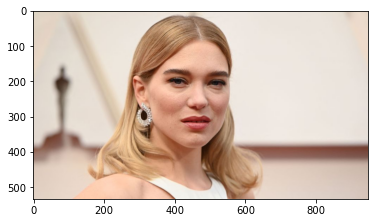

In [3]:
img = cv2.imread(image_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img);

In [4]:
if len(img.shape) == 2:
    img = img[:, :, None]
if img.shape[2] == 1:
    img = np.repeat(img, 3, axis=2)
elif img.shape[2] == 4:
    img = img[:, :, 0:3]

# normalize values to scale it between -1 to 1
img = (img - 127.5) / 127.5

img_h, img_w, img_c = img.shape
print(f'height = {img_h}, width = {img_w}, depth = {img_c}')

height = 533, width = 948, depth = 3


In [5]:
def get_scale_factor(im_h, im_w, ref_size):
    if max(im_h, im_w) < ref_size or min(im_h, im_w) > ref_size:
        if im_w >= im_h:
            im_rh = ref_size
            im_rw = int(im_w / im_h * ref_size)
        elif im_w < im_h:
            im_rw = ref_size
            im_rh = int(im_h / im_w * ref_size)
    else:
        im_rh = im_h
        im_rw = im_w

    im_rw = im_rw - im_rw % 32
    im_rh = im_rh - im_rh % 32

    x_scale_factor = im_rw / im_w
    y_scale_factor = im_rh / im_h

    return x_scale_factor, y_scale_factor

ref_size = 512
x, y = get_scale_factor(img_h, img_w, ref_size)
print(f'x = {x}, y = {y}')

x = 0.9451476793248945, y = 0.9606003752345216


In [6]:
img = cv2.resize(img, None, fx=x, fy=y, interpolation=cv2.INTER_AREA)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


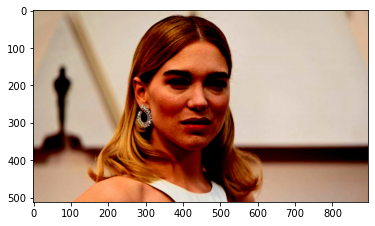

In [7]:
plt.imshow(img);

In [8]:
img = np.transpose(img)
img = np.swapaxes(img, 1, 2)
img = np.expand_dims(img, axis=0).astype("float32")

In [9]:
session = onnxruntime.InferenceSession("./model/pretrained/modnet.onnx", None)
input_name = session.get_inputs()[0].name
output_name = session.get_outputs()[0].name

In [10]:
result = session.run([output_name], {input_name: img})

In [21]:
mask = (np.squeeze(result[0]) * 255).astype("uint8")
mask = cv2.resize(mask, dsize=(img_w, img_h), interpolation=cv2.INTER_AREA)

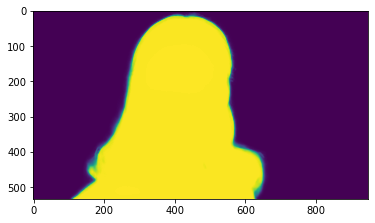

In [22]:
plt.imshow(mask);

In [24]:
cv2.imwrite('images/lea_matte.png', mask);

In [25]:
img_PIL = Image.open(image_path)
mask = Image.fromarray(mask)
img_PIL.putalpha(mask)

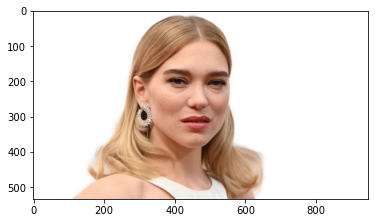

In [26]:
plt.imshow(img_PIL);

In [27]:
img_PIL.save('images/lea_cropped.png')